In [127]:
#pip install linearmodels

In [128]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [129]:
df=pd.read_csv("titanic.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [130]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [131]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [132]:
df.skew()

PassengerId    0.000000
Survived       0.478523
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           4.787317
dtype: float64

In [133]:
df["SibSp"]=np.cbrt(df["SibSp"])
df["SibSp"].skew()

1.0330593334477638

In [134]:
df["Parch"]=np.cbrt(df["Parch"])
df["Parch"].skew()

1.348334375571196

In [135]:
df["Fare"]=np.cbrt(df["Fare"])
df["Fare"].skew()

1.2303822111719223

<AxesSubplot:>

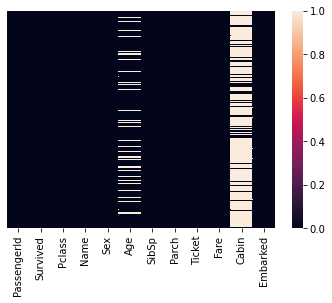

In [136]:
sns.heatmap(df.isnull(),yticklabels=False)

In [137]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    
    if pd.isnull(Age):
        if Pclass ==1:
            return 37  #replacing with 37 bcs average value of the first class is around 37
        
        elif Pclass ==2:
            return 29 #average value of 2nd class is near to 29
        
        else:
            return 24 # average value of 3rd class
        
    else:
        return Age

In [138]:
df["Age"] = df[["Age","Pclass"]].apply(impute_age,axis=1)

<AxesSubplot:>

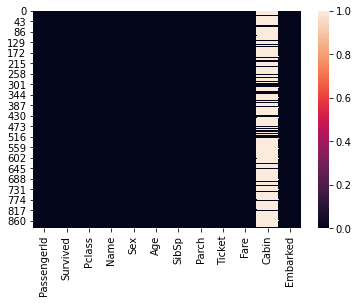

In [139]:
sns.heatmap(df.isnull())

In [140]:
# droping Cabin coloumn
df.drop("Cabin",axis=1,inplace=True)

In [141]:
embark=pd.get_dummies(df["Embarked"],drop_first=True)

In [142]:
label=LabelEncoder()
df["Sex"]=label.fit_transform(df["Sex"])

In [143]:
df.drop(["Embarked","Name","Ticket"],axis=1,inplace=True)

In [144]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,22.0,1.0,0.0,1.935438
1,2,1,1,0,38.0,1.0,0.0,4.146318
2,3,1,3,0,26.0,0.0,0.0,1.993730
3,4,1,1,0,35.0,1.0,0.0,3.758647
4,5,0,3,1,35.0,0.0,0.0,2.004158


# OLS Model

In [145]:
# Select the features to use in the model
features = ['Age', 'Sex', 'Pclass', 'Fare']

In [146]:
# Create a new dataframe with only the selected features
X = df[features]

In [147]:
# Create a new dataframe with the target variable
y = df.loc[X.index]['Survived']

In [148]:
# Add a constant to the features dataframe
X = sm.add_constant(X)

In [149]:
# Fit the OLS model
model = sm.OLS(y, X).fit()

In [150]:
# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     138.6
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           5.56e-92
Time:                        10:47:49   Log-Likelihood:                -405.48
No. Observations:                 891   AIC:                             821.0
Df Residuals:                     886   BIC:                             844.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2989      0.106     12.257      0.0

# 2SLS Model

In [151]:
# Define the endogenous variable and the instrumental variable
endog = 'Fare'
instr = 'SibSp'

In [152]:
# Define the exogenous variables
exog = ['Age', 'Sex', 'Pclass']

In [153]:
# Create the first stage regression model
X = sm.add_constant(df[instr])
first_stage = sm.OLS(df[endog], X).fit()

In [154]:
# Extract the predicted values of the endogenous variable
df['predicted_fare'] = first_stage.predict()

In [155]:
# Create the second stage regression model
X = sm.add_constant(df[exog + ['predicted_fare']])
second_stage = sm.OLS(df[endog], X).fit()

In [156]:
# Print the results
print(first_stage.summary())
print(second_stage.summary())

                            OLS Regression Results                            
Dep. Variable:                   Fare   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     123.7
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           5.29e-27
Time:                        10:47:49   Log-Likelihood:                -1268.1
No. Observations:                 891   AIC:                             2540.
Df Residuals:                     889   BIC:                             2550.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5183      0.040     62.385      0.0

# Logistic Regression

In [157]:
# split the variable as x and y
x =df.drop(columns=["Survived"])
y = df[["Survived"]]

In [158]:
# function for getting proper random state which gives best accuracy
maxAccu=0
maxRs=0
for i in range(100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=i)
    lr =LogisticRegression()
    lr.fit(x_train,y_train)
    pred=lr.predict(x_test)
    acc=accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRs=i

print("best accuracy is",maxAccu,"on random_state",maxRs)        

best accuracy is 0.8372881355932204 on random_state 78


In [159]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=78)

In [160]:
def eval(r):
    model=r
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    acc = accuracy_score(y_test,pred)
    f_score = f1_score(y_test,pred)
    scr = cross_val_score(model,x,y,cv=3,scoring="f1")
    print("Accuracy score is:",acc)
    print("F1 score is:",f_score)
    print(confusion_matrix(y_test,pred))
    print("\n")
    print(classification_report(y_test,pred))
    print("\n")
    print("cross validation score :",scr.mean())

In [161]:
eval(LogisticRegression())

Accuracy score is: 0.8372881355932204
F1 score is: 0.7837837837837838
[[160  24]
 [ 24  87]]


              precision    recall  f1-score   support

           0       0.87      0.87      0.87       184
           1       0.78      0.78      0.78       111

    accuracy                           0.84       295
   macro avg       0.83      0.83      0.83       295
weighted avg       0.84      0.84      0.84       295



cross validation score : 0.6931333329142211
